In [1]:
%%capture

import numpy as np
import pandas as pd
import xarray as xr

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode()
from IPython.display import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

from tqdm import tqdm

from trackml.dataset import load_event

I won't explain the content of this competition here, everything can be found on the kaggle site: https://www.kaggle.com/c/trackml-particle-identification. However, I will only analyze one single event in this notebook (because I don't have a lot of computing power at hand). This event is visualized in a few graphs below.

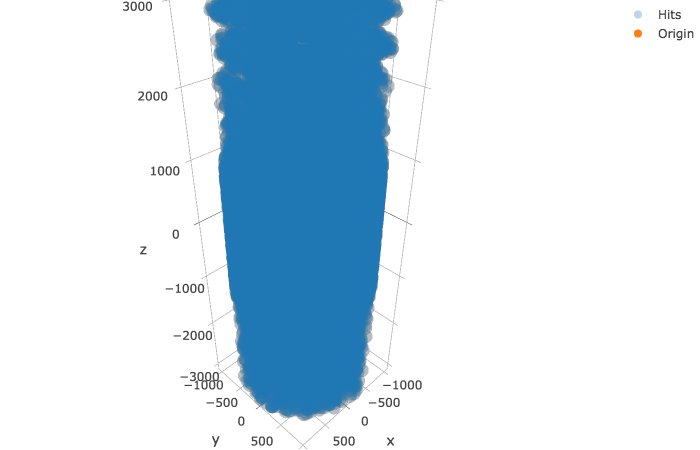

In [2]:
# Load data
hits, cells, particles, truth = load_event("./train_100_events/event000001000")
truth.index = truth.hit_id
hits.index = hits.hit_id

# Add "distance from origin"-column and sort by it
truth['dist'] = (truth.tx**2 + truth.ty**2 + truth.tz**2) ** (1/2)
truth = truth.sort_values('dist')

# Plot all hits
trace1 = go.Scatter3d(x=truth.tx, y=truth.ty, z=truth.tz, mode='markers', opacity=0.3, name="Hits")
trace2 = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', opacity=1, name="Origin")
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace1, trace2], layout=layout)
# py.iplot(fig)

Image('fig1.png')

In [3]:
# Two test tracks
track1 = truth[truth.particle_id == truth.loc[20906].particle_id]
track2 = truth[truth.particle_id == truth.loc[22405].particle_id]

track1

hit_id         particle_id          tx          ty          tz  \
hit_id                                                                   
20906    20906  950260552167325696   -3.715120   32.531200  -28.693501   
29287    29287  950260552167325696  -10.520200   71.067299  -57.998402   
35612    35612  950260552167325696  -20.975201  113.817001  -90.823502   
42232    42232  950260552167325696  -38.887001  167.647995 -132.860992   
73760    73760  950260552167325696  -78.810699  252.750000 -202.261993   
80449    80449  950260552167325696 -132.494995  332.373993 -272.451996   
86907    86907  950260552167325696 -244.658997  440.040009 -386.165009   
92821    92821  950260552167325696 -395.536011  523.101013 -512.562012   
108754  108754  950260552167325696 -601.302979  561.273010 -666.289001   

             tpx       tpy       tpz    weight         dist  
hit_id                                                       
20906  -0.051091  0.364180 -0.275196  0.000016    43.536171  
29287  -0.075847  0.359430 -0.274471  0.000013    92.331202  
35612  -0.099410  0.351922 -0.271879  0.000010   147.116198  
42232  -0.131641  0.341420 -0.270685  0.000008   217.416866  
73760  -0.179820  0.318319 -0.266942  0.000005   333.172030  
80449  -0.229098  0.284209 -0.266186  0.000005   449.730457  
86907  -0.291042  0.219140 -0.266104  0.000005   634.520784  
92821  -0.341102  0.127076 -0.265053  0.000008   832.347997  
108754 -0.361658  0.002130 -0.266721  0.000010  1058.552668

In [4]:
track2

hit_id         particle_id          tx          ty           tz  \
hit_id                                                                    
22405    22405  468379102890426368   31.363001   -2.240470    49.250099   
31033    31033  468379102890426368   71.755699   -3.584530   109.389999   
38293    38293  468379102890426368  115.221001   -3.005630   174.029999   
44866    44866  468379102890426368  171.330994    0.850648   258.066010   
44872    44872  468379102890426368  173.184998    1.036430   260.854004   
76732    76732  468379102890426368  260.217987   13.868400   392.063995   
83789    83789  468379102890426368  353.845001   37.641102   535.929016   
83778    83778  468379102890426368  359.763000   39.498501   545.138000   
90693    90693  468379102890426368  488.882996   90.821198   751.671021   
97056    97056  468379102890426368  636.452026  179.432999  1008.159973   
118379  118379  468379102890426368  744.026978  269.036011  1217.500000   
118915  118915  468379102890426368  870.002014  412.187012  1505.500000   

             tpx       tpy       tpz    weight         dist  
hit_id                                                       
22405   0.555573 -0.030916  0.827233  0.000014    58.431411  
31033   0.555913 -0.005662  0.826708  0.000012   130.873605  
38293   0.554995  0.020648  0.825945  0.000010   208.737528  
44866   0.550073  0.054562  0.827046  0.000008   309.762964  
44872   0.550368  0.054847  0.826769  0.000007   313.111689  
76732   0.542548  0.108607  0.823840  0.000005   470.765235  
83789   0.529077  0.164183  0.822516  0.000004   643.306328  
83778   0.528109  0.166867  0.822467  0.000004   654.343182  
90693   0.496812  0.242259  0.821913  0.000004   901.257108  
97056   0.446866  0.323151  0.822002  0.000006  1205.675744  
118379  0.396525  0.379051  0.822572  0.000007  1451.985795  
118915  0.321804  0.435167  0.824130  0.000008  1786.989647

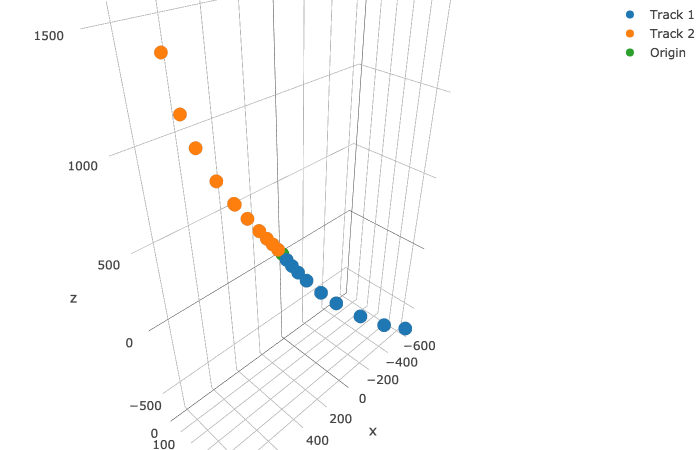

In [5]:
# Visualize test tracks

trace1 = go.Scatter3d(x=track1.tx, y=track1.ty, z=track1.tz, mode='markers', name="Track 1")
trace2 = go.Scatter3d(x=track2.tx, y=track2.ty, z=track2.tz, mode='markers', name="Track 2")
trace3 = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', name="Origin")
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
#py.iplot(fig)

Image('fig2.png')

Now the task is to find these two (and all of the other) tracks from the unannotated mess of points above.
A logical first step is to look for the first hits of the track. One might expect these to be the ones closest to the origin point, but because of the cylindrical structure of the detector, distance isn't the way to go, as can be seen below, where all _actual_ first hits are plottet (for orientation, both example tracks are also plottet):

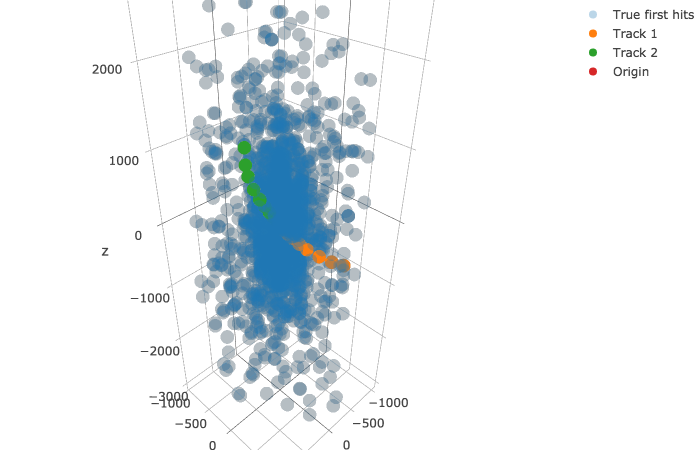

In [6]:
# True first hits

first_true = truth.drop_duplicates(subset='particle_id')

trace1 = go.Scatter3d(x=first_true.tx, y=first_true.ty, z=first_true.tz, mode='markers', opacity=0.3, name="True first hits")
trace2 = go.Scatter3d(x=track1.tx, y=track1.ty, z=track1.tz, mode='markers', opacity=1, name="Track 1")
trace3 = go.Scatter3d(x=track2.tx, y=track2.ty, z=track2.tz, mode='markers', opacity=1, name="Track 2")
trace4 = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', opacity=1, name="Origin")
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
#py.iplot(fig)

Image('fig3.png')

It is evident that most first hits lie on the innermost cylindrical detector, as is to be expected. However, a lot of random mess can be seen everywhere, where the particle apparently was not detected by detectors closer to the origin. To predict these first hits, I used a random forest classifier.

In [7]:
# Predict first hits

X = truth
y = truth.hit_id.isin(first_true.hit_id)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4)

model_first = RandomForestClassifier()
model_first.fit(X_train, y_train)

print("Confusion Matrix of test data:\n", confusion_matrix(y_test, model_first.predict(X_test)))

Confusion Matrix of test data:
 [[27288   262]
 [  501  2184]]


These results are not great, but they would probably get better if more data was used to train the classifier. Below is a plot of what the model predicts as the first hits, but remember that it was trained on 3/4 of exactly these points, so if it gets a lot correct that is not coincidence or brilliance, but just the fact that the model was fit to this data.

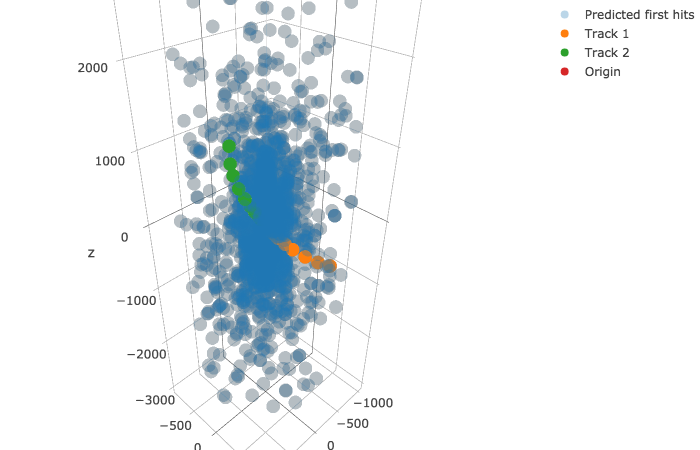

In [8]:
# Predicted first hits

y_pred = model_first.predict(truth)
first_pred = truth[y_pred]

trace1 = go.Scatter3d(x=first_pred.tx, y=first_pred.ty, z=first_pred.tz, mode='markers', opacity=0.3, name="Predicted first hits")
trace2 = go.Scatter3d(x=track1.tx, y=track1.ty, z=track1.tz, mode='markers', opacity=1, name="Track 1")
trace3 = go.Scatter3d(x=track2.tx, y=track2.ty, z=track2.tz, mode='markers', opacity=1, name="Track 2")
trace4 = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', opacity=1, name="Origin")
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
#py.iplot(fig)

Image('fig4.png')

In [9]:
# Similarity

print("Total number of predicted first hits:", y_pred.sum())
print("Total errors made:", (y_pred ^ y).sum())
print("{:f}% of the prediction is correct".format((len(y) - (y_pred ^ y).sum()) / len(y)))

Total number of predicted first hits: 10184
Total errors made: 938
0.992244% of the prediction is correct


With that, we can now turn to the second hits. This is where it gets more tricky, and the huge amount of data really becomes a problem. If one were to look for a second hit for every of our predicted first hits among all of the data, there would be far too many possibilities:

In [10]:
num = len(y_pred) * (len(truth) - 1)    # We can exclude the first hit itself as second hit 🎉
print("Number of possibilities:", num)

Number of possibilities: 14626120782


Now if each of the calculations took only ten microsecond, it would still take:

In [11]:
print(pd.Timedelta('10 us') * num)

1 days 16:37:41.207820


to predict all possible second hits for one event! Now suppose we would take the ten most likely second hits per first hit and predict the third hits for those, that would then take

In [12]:
# This time, we can exclude two hits on our search for the third one!
num = len(y_pred) * 10 * (len(truth) - 2)
print(pd.Timedelta('10 us') * num)

16 days 22:16:39.984300


Alright, that is definetely too long. But, because we are not looking for a random point among all other ones, we can just exclude most points when looking for a second hit. For example, we know the particle physically has to continue moving away from the origin. That already excludes all hits that are closer to the origin than our first hit. Also, the second hit won't be too far away from the first hit, we can calculate the average distance of the two:

In [13]:
l = np.array([])
for _, hits in truth.groupby("particle_id"):
    if len(hits) > 1:
        l = np.append(l, [np.sqrt((hits.tx.iloc[1] - hits.tx.iloc[0])**2 
                                   + (hits.ty.iloc[1] - hits.ty.iloc[0])**2 
                                   + (hits.tz.iloc[1] - hits.tz.iloc[0])**2)])

print(f"The average distance between first and second hit is {l.mean():.2f} "
      f"with a standard deviation of {l.std():.2f}.")

The average distance between first and second hit is 89.87 with a standard deviation of 151.94.


Now we can define a cone with the first hit being the starting point in which the second point must be. We can use efficient linear algebra libraries to rapidly calculate these cones:

In [14]:
%%time

# First layer, I only use 5000 points because otherwise my laptop crashes.
layer = first_true.iloc[1:5001]

# Put all hits into a tensor with coordinates hit_id, and prev; prev here is the hit_id of the previous hit (namely the first hit)
x = xr.DataArray(np.resize(truth.tx.values, (len(layer), len(truth))).T, coords={'hit_id': truth.hit_id.values, 'prev': layer.hit_id.values}, dims=['hit_id', 'prev'])
y = xr.DataArray(np.resize(truth.ty.values, (len(layer), len(truth))).T, coords={'hit_id': truth.hit_id.values, 'prev': layer.hit_id.values}, dims=['hit_id', 'prev'])
z = xr.DataArray(np.resize(truth.tz.values, (len(layer), len(truth))).T, coords={'hit_id': truth.hit_id.values, 'prev': layer.hit_id.values}, dims=['hit_id', 'prev'])
ds = x.to_dataset(name='x')
ds['y'] = y
ds['z'] = z

# Put first hits in similar shape as all other hits (xarray)
X = layer[['tx', 'ty', 'tz']].to_xarray()
X = X.rename({'hit_id': 'prev', 'tx': 'x', 'ty': 'y', 'tz': 'z'})

# Calculate the angle between all first hits and possible second hits
xp = ds - X    # Elements of xp are the vectors between the first hit (x) and possible second hit (p)
xpl = (xp.x**2 + xp.y**2 + xp.z**2)**(1/2)
p = xp/xpl     # Norm all vectors

ox = X         # Elements of ox are the vectors between the origin (o) and the first hit (x)
oxl = (ox.x**2 + ox.y**2 + ox.z**2)**(1/2)
n = ox/oxl     # Norm all vectors

s = n * p      # Calculate cosine of angles between points

# Exclude all hits where the angle is > 36.9° or the distance is < 300
cones = ((((s.x + s.y + s.z) > 0.8)) & (xpl < 300)).T

CPU times: user 1min 8s, sys: 2min 54s, total: 4min 3s
Wall time: 4min 34s


To illustrate this result I will plot the cone of the first test track below:

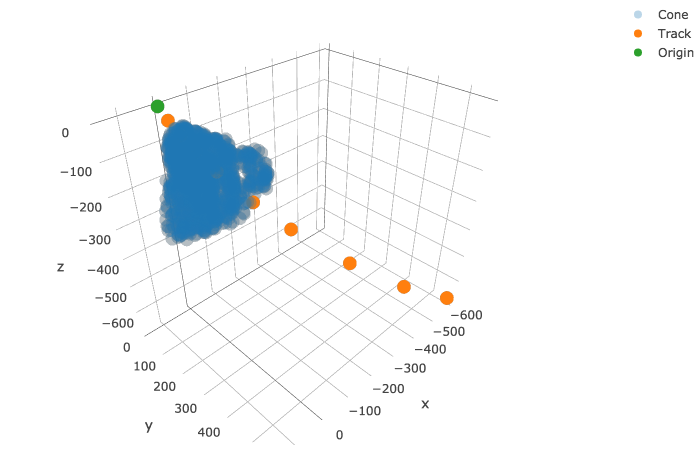

In [15]:
# Visualize cones
cone1 = truth[cones.sel(prev=20906).values]
trace1 = go.Scatter3d(x=cone1.tx, y=cone1.ty, z=cone1.tz, mode='markers', opacity=0.3, name="Cone")
trace2 = go.Scatter3d(x=track1.tx, y=track1.ty, z=track1.tz, mode='markers', opacity=1, name="Track")
trace3 = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', opacity=1, name="Origin")
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
#py.iplot(fig)

Image('fig5.png')

Now these cones we can work with. A simple neural net can classify between "looks like a second hit" and "does not look like a second hit" among the hits inside a cone. To train the net I will use the second hit as a positive example and 10 random hits from the cone as negative example, so that the distribution isn't too skewed towards negative examples.

In [16]:
# Process data for NN

remains = ds.where(cones)    # Hits inside cones

X = np.zeros(6)
y = np.array([])

for fhit in tqdm(ds.prev):
    # Get 10 random hits from cone
    remain = remains.sel(prev=fhit).dropna('hit_id')
    remain = remain.sel(hit_id=np.random.choice(remain.hit_id.values, 10)).to_dataframe()
    
    # Add the one true second hit
    try:
        t = truth[truth.particle_id == truth.particle_id.loc[int(fhit)]].iloc[1]
    except:
        continue
    
    remain = remain[remain.index != t.hit_id]
    prev = truth.loc[np.full((len(remain),), fhit)]
    y = np.concatenate((y, len(remain)*[0], [1]))
    X = np.vstack([X, np.vstack([prev.tx, prev.ty, prev.tz, remain.x.values, remain.y.values, remain.z.values]).T, 
                   [prev.tx.iloc[0], prev.ty.iloc[0], prev.tz.iloc[0], t.tx, t.ty, t.tz]])

X = X[1:]

100%|██████████| 5000/5000 [01:36<00:00, 51.66it/s]


In [17]:
# Train the NN

model_second = Sequential()
model_second.add(Dense(64, activation='relu', input_shape=(6,)))
model_second.add(Dense(64, activation='relu'))
model_second.add(Dense(64, activation='relu'))
model_second.add(Dense(64, activation='relu'))
model_second.add(Dense(64, activation='relu'))
model_second.add(Dense(1, activation='sigmoid'))
model_second.compile(optimizer='rmsprop', loss='binary_crossentropy')
model_second.fit(X, y, epochs=5)

Epoch 1/5
53878/53878 [==============================] - 3s 49us/step - loss: 0.1586
Epoch 2/5
53878/53878 [==============================] - 2s 43us/step - loss: 0.1057
Epoch 3/5
53878/53878 [==============================] - 2s 42us/step - loss: 0.0973
Epoch 4/5
53878/53878 [==============================] - 2s 44us/step - loss: 0.0907
Epoch 5/5
53878/53878 [==============================] - 2s 41us/step - loss: 0.0927


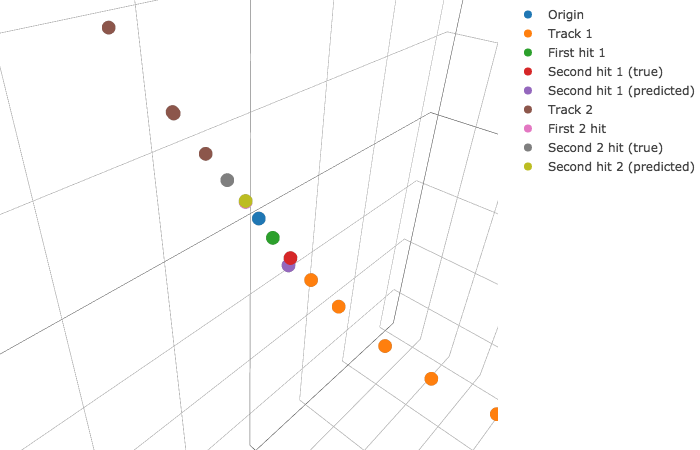

In [18]:
# Test the NN on the two test tracks

cone1 = truth[cones.sel(prev=20906).values][['tx', 'ty', 'tz']].values
X1 = np.hstack([np.repeat(truth.loc[20906][['tx', 'ty', 'tz']].values[np.newaxis], len(cone1), axis=0), cone1])
second_1 = cone1[np.argmax(model_second.predict(X1))]

cone2 = truth[cones.sel(prev=22405).values][['tx', 'ty', 'tz']].values
X2 = np.hstack([np.repeat(truth.loc[22405][['tx', 'ty', 'tz']].values[np.newaxis], len(cone2), axis=0), cone2])
second_2 = cone2[np.argmax(model_second.predict(X2))]

trace1 = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', opacity=1, name="Origin")

trace2 = go.Scatter3d(x=track1.tx.iloc[2:], y=track1.ty.iloc[2:], z=track1.tz.iloc[2:], mode='markers', opacity=1, name="Track 1")
trace3 = go.Scatter3d(x=[track1.tx.iloc[0]], y=[track1.ty.iloc[0]], z=[track1.tz.iloc[0]], mode='markers', opacity=1, name="First hit 1")
trace4 = go.Scatter3d(x=[track1.tx.iloc[1]], y=[track1.ty.iloc[1]], z=[track1.tz.iloc[1]], mode='markers', opacity=1, name="Second hit 1 (true)")
trace5 = go.Scatter3d(x=[second_1[0]], y=[second_1[1]], z=[second_1[2]], mode='markers', opacity=1, name="Second hit 1 (predicted)")

trace6 = go.Scatter3d(x=track2.tx.iloc[2:], y=track2.ty.iloc[2:], z=track2.tz.iloc[2:], mode='markers', opacity=1, name="Track 2")
trace7 = go.Scatter3d(x=[track2.tx.iloc[0]], y=[track2.ty.iloc[0]], z=[track2.tz.iloc[0]], mode='markers', opacity=1, name="First 2 hit")
trace8 = go.Scatter3d(x=[track2.tx.iloc[1]], y=[track2.ty.iloc[1]], z=[track2.tz.iloc[1]], mode='markers', opacity=1, name="Second 2 hit (true)")
trace9 = go.Scatter3d(x=[second_2[0]], y=[second_2[1]], z=[second_2[2]], mode='markers', opacity=1, name="Second hit 2 (predicted)")

layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9], layout=layout)
#py.iplot(fig)

Image('fig6.png')

The model accurately predicts the second hit of the first track, but fails to predict the second hit of the second track, though on a previous trial the same network predicted the second hit of the first track accurately.

To predict the third and subsequent hits we will use neural nets that use the previous hits as input and output the predicted position in space of the next hit. Then we can use the closest available hit as a prediction.

In [19]:
# Process data for NN

X = np.zeros(6)
y = np.zeros(3)

for fhit in tqdm(ds.prev):
    t = truth[truth.particle_id == truth.particle_id.loc[int(fhit)]]
    try:
        y = np.vstack([y, np.r_[t.iloc[2].tx, t.iloc[2].ty, t.iloc[2].tz]])
        X = np.vstack([X, np.r_[t.iloc[0].tx, t.iloc[0].ty, t.iloc[0].tz, 
                                t.iloc[1].tx, t.iloc[1].ty, t.iloc[1].tz]])
    except:
        continue
    
X = X[1:]
y = y[1:]

100%|██████████| 5000/5000 [00:14<00:00, 345.75it/s]


In [20]:
# Train the NN

model_third = Sequential()
model_third.add(Dense(64, activation='relu', input_shape=(6,)))
model_third.add(Dense(64, activation='relu'))
model_third.add(Dense(64, activation='relu'))
model_third.add(Dense(64, activation='relu'))
model_third.add(Dense(64, activation='relu'))
model_third.add(Dense(3))
model_third.compile(optimizer='rmsprop', loss='mse')
model_third.fit(X, y, epochs=20)

Epoch 1/20
4837/4837 [==============================] - 0s 96us/step - loss: 2230.0851
Epoch 2/20
4837/4837 [==============================] - 0s 39us/step - loss: 838.3017
Epoch 3/20
4837/4837 [==============================] - 0s 38us/step - loss: 825.0221
Epoch 4/20
4837/4837 [==============================] - 0s 37us/step - loss: 825.1955
Epoch 5/20
4837/4837 [==============================] - 0s 38us/step - loss: 783.8190
Epoch 6/20
4837/4837 [==============================] - 0s 38us/step - loss: 784.6124
Epoch 7/20
4837/4837 [==============================] - 0s 39us/step - loss: 784.2446
Epoch 8/20
4837/4837 [==============================] - 0s 40us/step - loss: 773.4479
Epoch 9/20
4837/4837 [==============================] - 0s 38us/step - loss: 752.6868
Epoch 10/20
4837/4837 [==============================] - 0s 39us/step - loss: 754.0583
Epoch 11/20
4837/4837 [==============================] - 0s 37us/step - loss: 755.4317
Epoch 12/20
4837/4837 [============================

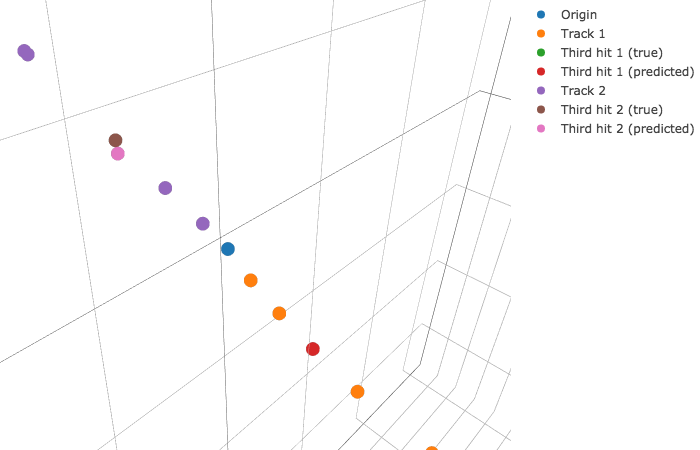

In [21]:
# Test the NN on the two test tracks

X1 = np.r_[track1.tx.iloc[0], track1.ty.iloc[0], track1.tz.iloc[0], track1.tx.iloc[1], track1.ty.iloc[1], track1.tz.iloc[1]]
third_1 = model_third.predict(X1[np.newaxis])[0]    # Predicted position
third_1 = truth.iloc[np.argmin(np.sqrt(np.sum((truth[['tx', 'ty', 'tz']].values - third_1)**2, axis=1)))]    # Nearest hit

X2 = np.r_[track2.tx.iloc[0], track2.ty.iloc[0], track2.tz.iloc[0], track2.tx.iloc[1], track2.ty.iloc[1], track2.tz.iloc[1]]
third_2 = model_third.predict(X2[np.newaxis])[0]
third_2 = truth.iloc[np.argmin(np.sqrt(np.sum((truth[['tx', 'ty', 'tz']].values - third_2)**2, axis=1)))]    # Nearest hit

trace1 = go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', opacity=1, name="Origin")

trace2 = go.Scatter3d(x=track1.tx, y=track1.ty, z=track1.tz, mode='markers', opacity=1, name="Track 1")
trace3 = go.Scatter3d(x=[track1.tx.iloc[2]], y=[track1.ty.iloc[2]], z=[track1.tz.iloc[2]], mode='markers', opacity=1, name="Third hit 1 (true)")
trace4 = go.Scatter3d(x=[third_1.tx], y=[third_1.ty], z=[third_1.tz], mode='markers', opacity=1, name="Third hit 1 (predicted)")

trace5 = go.Scatter3d(x=track2.tx, y=track2.ty, z=track2.tz, mode='markers', opacity=1, name="Track 2")
trace6 = go.Scatter3d(x=[track2.tx.iloc[2]], y=[track2.ty.iloc[2]], z=[track2.tz.iloc[2]], mode='markers', opacity=1, name="Third hit 2 (true)")
trace7 = go.Scatter3d(x=[third_2.tx], y=[third_2.ty], z=[third_2.tz], mode='markers', opacity=1, name="Third hit 2 (predicted)")

layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7], layout=layout)
#py.iplot(fig)

Image('fig7.png')

The model fails to predict the third hit for the second track, but correctly predicts the third hit for the first track. Again, the model probably would get better if it were trained on a lot more data, but this algorithm is also very rudimentary and can be improved a great deal if more time was invested.

However, I have already missed the deadline on this kaggle competition and won't continue work from here on.
Thank you very much for reading :)